# Déneigeuse théorie

In [1]:
import numpy as np
import networkx as nx

import random
from copy import copy

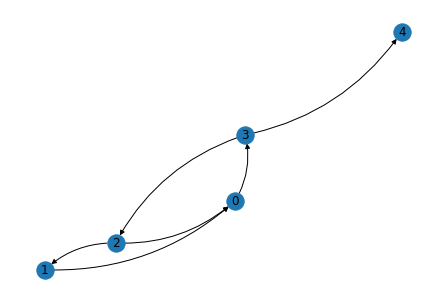

In [60]:
G = [(0,3,7),(0,2,3),
    (1,2,1),(1,7,2),
    (2,5,2), (2,4,3), (2,3,6),
    (3,8,9), (3,0,2),
    (4,5,2), (4,8,3),
    (5,4,2),(5,1,4),
    (6,8,2), (6,5,6), (6,7,4),
    (7,6,4), (7,9,4),
    (8,4,3), (8,3,3),
    (9,6,4),( 9,11,1), (10, 11, 1)]

#G = [(0, 1, 3), (1, 2, 3), (2, 3, 3), (3, 0, 3), (1, 3, 3), (0, 2, 3)]

G = [(1, 0, 3), (2, 0, 3), (2, 1, 3),(3, 2, 4), (0, 3, 3), (3, 4, 3)]

#G = [(0, 1, 3), (1, 2, 3), (2, 0, 5)]

#G = [(0, 1, 3), (2, 1, 4)]

#G = [(2, 1, 3), (1, 0, 3), (0, 2, 3), (0, 3, 5), (3, 4, 5), (4, 0, 5)]

#G = [(2, 1, 3), (1, 0, 3), (0, 2, 3), (0, 3, 4), (3, 4, 3), (1, 3, 3)]

def print_graph(G):
    '''
    Function printing a graph G by converting it to nxdigraph.
    '''
    maxi = 0
    for (n1, n2, w) in G:
        if (n1 > maxi):
            maxi = n1
        if (n2 > maxi):
            maxi = n2
    new_graph = nx.MultiDiGraph()
    new_graph.add_nodes_from(range(0, maxi + 1)) # adding all nodes to the graph
    for (n1, n2, w) in G: # adding all edges with their weight
        new_graph.add_edge(n1, n2, weight=w)
    nx.draw(new_graph, with_labels=True, connectionstyle='arc3,rad=0.2')


print_graph(G)

Dans ce notebook nous allons expliquer le fonctionnement de notre algorithme sur un exemple d'un petit graphe. Ce gaphe est oriente et peut represeneter un arrondissement de Montreal. En effet, notre graphe est connexe car tout comme dans un arrondissement, on peut acceder de tout point A a tout point B. Les arretes du graphe peuvent etre vues comme les routes, elles sont soit a sens unique soit a double sens.

### Comment trouver le chemin le plus rapide ?

La premiere methode qui nous est venu a l'esprit etait de construire un parcours eulerien. Notre graphe etant oriente et n'etant pas forcement eulerien, l'algorithme du parcours eulerien necessite quelques modifications:

1. Premierement on transforme le graphe en un graphe oriente. Les arretes a double sens vont se transformer en double arretes.

2. Ensuite on transforme notre graphe en un graphe eulerien en ajoutant des arretes necessaires

3. On calcule le chemin eulerien

4. La derniere etape consiste a reconstruire notre chemin sur le graphe oriente de depart. Donc lorsqu'on va tomber sur des arretes inexistantes nous allons juste les remplacer par les nouveaux plus courts chemins qu'on trouve.

In [61]:
# MON PROPRE ALGO POUR TRANSFORMER UN GRAPHE ORIENTE EN UN GRAPHE EULERIEN ORIENTE
def directed_to_eulerien(G):
    # create a copy of G to not modify the initial graph
    G_copy = copy(G)
    # create lists of vertices with their in and out (vertice_number, inv, outv)
    in_bigger = [] # in = out + 1
    out_bigger = [] # out = in + 1
    in_dominant = [] # in > out + 1
    out_dominant = [] # out > in + 1
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    for i in range(m + 1): # for each vertice of the graph count the number of in and out
        inv = 0
        outv = 0
        for (a, b, w) in G:
            if (i == a):
                outv += 1
            if (i == b):
                inv += 1
        # adding all vertices in their respective list        
        if (inv == outv + 1):
            in_bigger.append((i, inv, outv))
        elif (outv == inv + 1):
            out_bigger.append((i, inv, outv))
        elif (inv > outv + 1):
            in_dominant.append((i, inv, outv))
        elif (inv != outv):
            out_dominant.append((i, inv, outv))
    
    while (len(out_bigger) > 1 or len(in_bigger) > 1) or len(in_dominant) > 0 or len(out_dominant) > 0:
        while (len(in_bigger) > 1):
            (i, inv, outv) = in_bigger[0]
            if (len(out_dominant) > 0):
                (i2, inv2, outv2) = out_dominant[0]
                # adding edge 1 -> 2
                G_copy.append((i, i2, 10)) # we dont care here about weight because this road doesnt exist and we will no go there
                # removing first vertice from the list because it now has equla number of in and out
                in_bigger.pop(0)
                if (inv2 + 1 == outv2):
                    out_dominant.pop(0) # if new inv == outv remove
                elif (inv2 + 2 == outv2):
                    out_dominant.pop(0)
                    out_bigger.append(((i2, inv2 + 1, outv2))) # if 'out dominant' node becames 'out bigger' node
                else:
                    out_dominant[0] = (i2, inv2 + 1, outv2) # if its not equal just update new inv
            elif (len(out_bigger) > 0):
                (i2, inv2, outv2) = out_bigger[0]
                # adding edge 1 -> 2
                G_copy.append((i, i2, 10))
                in_bigger.pop(0)
                out_bigger.pop(0)
            else:
                print("1 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(out_bigger) > 1):
            (i, inv, outv) = out_bigger[0]
            if (len(in_dominant) > 0):
                (i2, inv2, outv2) = in_dominant[0]
                G_copy.append((i2, i, 10))
                out_bigger.pop(0)
                if (outv2 + 1 == inv2):
                    in_dominant.pop(0)
                elif (outv2 + 2 == inv2):
                    in_dominant.pop(0)
                    in_bigger.append(((i2, inv2, outv2 + 1))) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i2, inv2, outv2 + 1)
            elif (len(in_bigger) > 0):
                (i2, inv2, outv2) = in_bigger[0]
                G_copy.append((i2, i, 10))
                out_bigger.pop(0)
                in_bigger.pop(0)
            else:
                print("2 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(in_dominant) > 0):
            (i, inv, outv) = in_dominant[0]
            if (len(out_dominant) > 0):
                (i2, inv2, outv2) = out_dominant[0]
                G_copy.append((i, i2, 10))
                if (outv + 1 == inv):
                    in_dominant.pop(0)
                elif (outv + 2 == inv):
                    in_dominant.pop(0)
                    in_bigger.append((i, inv, outv + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i, inv, outv + 1)
                # do the same for out_dominant
                if (inv2 + 1 == outv2):
                    out_dominant.pop(0)
                elif (inv2 + 2 == outv2):
                    out_dominant.pop(0)
                    out_bigger.append((i2, inv2 + 1, outv2)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i2, inv2 + 1, outv2)
            elif (len(out_bigger) > 0):
                (i2, inv2, outv2) = out_bigger[0]
                G_copy.append((i, i2, 10))
                out_bigger.pop(0)
                if (outv + 1 == inv):
                    in_dominant.pop(0)
                elif (outv + 2 == inv):
                    in_dominant.pop(0)
                    in_bigger.append((i, inv, outv + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i, inv, outv + 1)
            
            else:
                print("3 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(out_dominant) > 0):
            (i, inv, outv) = out_dominant[0]
            if (len(in_dominant) > 0):
                (i2, inv2, outv2) = in_dominant[0]
                G_copy.append((i2, i, 10))
                if (inv + 1 == outv):
                    out_dominant.pop(0)
                elif (inv + 2 == outv):
                    out_dominant.pop(0)
                    out_bigger.append((i, inv + 1, outv)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i, inv + 1, outv)
                # do the same for in_dominant
                if (outv2 + 1 == inv2):
                    in_dominant.pop(0)
                elif (outv2 + 2 == inv2):
                    in_dominant.pop(0)
                    in_bigger.append((i2, inv2, outv2 + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i2, inv2, outv2 + 1)
            elif (len(in_bigger) > 0):
                (i2, inv2, outv2) = in_bigger[0]
                G_copy.append((i2, i, 10))
                in_bigger.pop(0)
                if (inv + 1 == outv):
                    out_dominant.pop(0)
                elif (inv + 2 == outv):
                    out_dominant.pop(0)
                    out_bigger.append((i, inv + 1, outv)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i, inv + 1, outv)
            
            else:
                print("4 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
                
    
    return G_copy        

In [62]:
# Hierholzer’s Algorithm for directed graph

# function converting our graph to an adj list
def graph_to_adj(G):
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    adj = [[] for _ in range(m + 1)]
    
    for (a, b, w) in G:
        adj[a].append(b)
    return adj
    
def get_eulerian_path(G):
  

    adj = graph_to_adj(G)
    # adj represents the adjacency list of
    # the directed graph
    # edge_count represents the number of edges
    # emerging from a vertex
        
    edge_count = dict()
  
    for i in range(len(adj)):
  
        # find the count of edges to keep track
        # of unused edges
        edge_count[i] = len(adj[i])
  
    if len(adj) == 0:
        return # empty graph
  
    # Maintain a stack to keep vertices
    curr_path = []
  
    # vector to store final circuit
    circuit = []
  
    # find the start vertex (indeg + 1 = outdeg) if there is no start vertex, we have to take the vertex next to the end,
    # if the re is no end we can take any vertex
    # create lists of vertices with their in and out (vertice_number, inv, outv)
    #in_bigger = (0, 0, 0) # in = out + 1
    start_vertex = (0, 0, 0) # out = in + 1
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    for i in range(m + 1): # for each vertice of the graph count the number of in and out
        inv = 0
        outv = 0
        for (a, b, w) in G:
            if (i == a):
                outv += 1
            if (i == b):
                inv += 1
        # adding all vertices in their respective list        
        #if (inv == outv + 1):
        #    in_bigger = (i, inv, outv)
        if (outv == inv + 1):
            start_vertex = (i, inv, outv)
    #if (start_vertex == (0, 0, 0)):
        # take a vertex
    
    # find the end vertex (outdeg + 1 = indeg) if there is no end vertex
    
    
    # start from any vertex
    curr_path.append(start_vertex[0])
    curr_v = start_vertex[0] # Current vertex
  
    while len(curr_path):
  
        # If there's remaining edge
        if edge_count[curr_v]:
  
            # Push the vertex
            curr_path.append(curr_v)
  
            # Find the next vertex using an edge
            next_v = adj[curr_v][-1]
  
            # and remove that edge
            edge_count[curr_v] -= 1
            adj[curr_v].pop()
  
            # Move to next vertex
            curr_v = next_v
  
        # back-track to find remaining circuit
        else:
            circuit.append(curr_v)
  
            # Back-tracking
            curr_v = curr_path[-1]
            curr_path.pop()
  
    # we've got the path, now return its reverse
    rev = []
    for item in circuit[::-1]:
        rev.append(item)
    return rev

[(1, 0, 3), (2, 0, 3), (2, 1, 3), (3, 2, 4), (0, 3, 3), (3, 4, 3)]


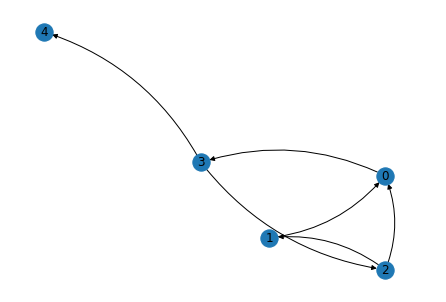

In [63]:
def graph_covering(G):
    #copie de G pour pas le modfier
    cp_G = copy(G)
    return cp_G

G_copy = copy(G)
G_eul = directed_to_eulerien(G_copy)
print_graph(G)
print(G)

[(1, 0, 3), (2, 0, 3), (2, 1, 3), (3, 2, 4), (0, 3, 3), (3, 4, 3), (0, 2, 10)]


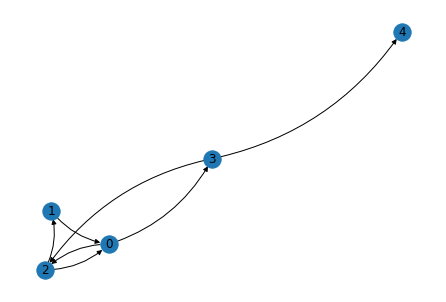

In [64]:
print_graph(G_eul)
print(G_eul)

In [65]:
arr_g = get_eulerian_path(G_eul)
print(arr_g)

[3, 2, 1, 0, 2, 0, 3, 4]


In [70]:
def dijkstra(G, start, end, is_directed):
    # conversions
    #start = str(s)
    #end = str(e)
    graph = {}
    # calculate total number of nodes
    total = 0
    for (a, b, w) in G:
        if a > total:
            total = a
        if b > total:
            total = b
    for i in range(total + 1):
        graph[i] = {}
    for (a, b, w) in G:
        graph[a][b] = w
        if not is_directed: # if the graph is not directed add the same edge but in reverse direction
            graph[b][a] = w
    
    # empty dictionary to hold distances
    distances = {} 
    # list of vertices in path to current vertex
    predecessors = {} 
    
    # get all the nodes that need to be assessed
    to_assess = graph.keys() 

    # set all initial distances to infinity
    #  and no predecessor for any node
    for node in graph:
        distances[node] = float('inf')
        predecessors[node] = None
    
    # set the initial collection of 
    # permanently labelled nodes to be empty
    sp_set = []

    # set the distance from the start node to be 0
    distances[start] = 0
    
    # as long as there are still nodes to assess:
    while len(sp_set) < len(to_assess):

        # chop out any nodes with a permanent label
        still_in = {node: distances[node]\
                    for node in [node for node in\
                    to_assess if node not in sp_set]}

        # find the closest node to the current node
        closest = min(still_in, key = distances.get)

        # and add it to the permanently labelled nodes
        sp_set.append(closest)
        
        # then for all the neighbours of 
        # the closest node (that was just added to
        # the permanent set)
        for node in graph[closest]:
            # if a shorter path to that node can be found
            if distances[node] > distances[closest] +\
                       graph[closest][node]:

                # update the distance with 
                # that shorter distance
                distances[node] = distances[closest] +\
                       graph[closest][node]

                # set the predecessor for that node
                predecessors[node] = closest
                
    # once the loop is complete the final 
    # path needs to be calculated - this can
    # be done by backtracking through the predecessors
    path = [end]
    while start not in path:
        if (predecessors[path[-1]] == None): # it means that path doesnt exist
            return None, 0
        path.append(predecessors[path[-1]])
    
    # return the path in order start -> end, and it's cost
    return path[::-1], distances[end]

'''
EXAMPLE OF DICT:
graph = {
        '1': {'2': 1, '4':  1},
        '2': {'1': 1, '4':  1, '3':  2},
        '3': {'2':2, '4':1, '5':1, '6':1},
        '4': {'1':  1, '2':  1, '3':1, '5':2, '6':15},
        '5': {'3': 1, '4':2, '6':1},
        '6': {'3': 1, '4':15, '5':1}
     }
'''

#G = [(1, 2, 1), (1, 4, 1), (2, 4, 1), (2, 3, 2), (3, 4, 1), (3, 5, 1), (3, 6, 1), (4, 5, 2), (4, 6, 15), (5, 6, 1)]
#convert_G_to_dict(G)
#p, d = dijkstra(graph, start='1', end='6')
#p
p, d = dijkstra(G, 0, 2, is_directed=True)
print(arr_g)
print(p)

[3, 2, 1, 0, 2, 0, 3, 4]
[0, 3, 2]


On remplace les arrêtes qui ne devraient pas exister par le chemin le plus court entre les deux noeuds en utilisant l'algorithme de dijkstra. On l'execute une premiere fois en considérant le graph comme orienté, et si on ne peut trouver de resultat (cul de sac par exemple), on le relance en considérant cette fois que le graph n'est pas orienté.
On remplace ensuite les deux noeuds par le chemin correspondant.

In [83]:
def graph_to_adj_weighted(G):
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    adj = [[] for _ in range(m + 1)]
    
    for (a, b, w) in G:
        adj[a].append((b,w))
    return adj

def replace_nodes(G, arr, adj):
    arr_g = copy(arr)
    i = 0
    while i < len(arr_g)-1:
        a,b = arr_g[i],arr_g[i+1]
        adj_a = adj[a]
        flag = False
        for e in adj[a]: #check si b est dans la liste d'adjacence de a
            if (e[0] == b):
                flag = True
                break
        if (flag != True):
            p, d = dijkstra(G, a, b, is_directed=True)
            if (d == 0):
                p, d = dijkstra(G, a, b, is_directed=False)
            for e in p:
                arr_g.insert(i, e)
                i += 1
            arr_g.pop(i)
            arr_g.pop(i)
        i+= 1
    return arr_g
        
true_path = replace_nodes(G, arr_g, graph_to_adj_weighted(G))
print(true_path)

[3, 2, 1, 0, 3, 2, 0, 3, 4]


# Recherche du plus court chemin entre deux noeuds en utilisant l'algorithme de Dijkstra


1. Marquer tous les sommets non visités. Créer un ensemble de tous les sommets non visités.

2. Attribuer une valeur de distance nulle au sommet source et une valeur de distance infinie à tous les autres sommets.

3. Définir le sommet source comme sommet actuel

4. Pour le sommet actuel, considérer tous ses voisins non visités et calculer leurs distances provisoires à travers le courant. (distance actuelle + poids de l'arête correspondante) 

5. Comparer la distance nouvellement calculée à la valeur assignée actuelle (peut être l'infini pour certains sommets) et attribuez la plus petite.

6. Après avoir considéré tous les voisins non visités du sommet actuel, marquer le courant comme visité et le supprimer de l'ensemble non visité.

7. De même, continuer pour tous les sommets jusqu'à ce que tous les nœuds soient visités.

In [9]:


def dijkstra(G, s, path):
    adj = graph_to_adj_weighted(G)
    
    infi = 100000000
    dist = [infi for i in range(len(adj))]
   
    # bool array that shows
    # whether the vertex 'i'
    # is visited or not
    visited = [False for i in range(len(adj))]
     
    for i in range(len(adj)):       
        path[i] = -1
    dist[s] = 0;
    path[s] = -1;
    current = s;
   
    # Set of vertices that has
    # a parent (one or more)
    # marked as visited
    sett = set()    
    while (True):
           
        # Mark current as visited
        visited[current] = True;
        for i in range(len(adj[current])): 
            v,_ = adj[current][i];           
            if (visited[v]):
                continue;
   
            # Inserting into the
            # visited vertex
            sett.add(v);
            alt = dist[current] + adj[current][i][1];
   
            # Condition to check the distance
            # is correct and update it
            # if it is minimum from the previous
            # computed distance
            if (alt < dist[v]):      
                dist[v] = alt;
                path[v] = current;       
        if current in sett:           
            sett.remove(current);       
        if (len(sett) == 0):
            break;
   
        # The new current
        minDist = infi;
        index = 0;
   
        # Loop to update the distance
        # of the vertices of the graph
        for a in sett:       
            if (dist[a] < minDist):          
                minDist = dist[a];
                index = a;          
        current = index;  
    return dist;

In [10]:
s=0
path = [0 for i in range(len(G_eul))];
dist = dijkstra(G, s, path)
for i in range(len(dist)):
        if (dist[i] == 100000000):
         
            print("{0} and {1} are not " +
                              "connected".format(i, s));
            continue;       
        print("Distance of {}th vertex from source vertex {} is: {}".format(
                          i, s, dist[i]));
     

Distance of 0th vertex from source vertex 0 is: 0
Distance of 1th vertex from source vertex 0 is: 9
Distance of 2th vertex from source vertex 0 is: 3
Distance of 3th vertex from source vertex 0 is: 7
Distance of 4th vertex from source vertex 0 is: 6
Distance of 5th vertex from source vertex 0 is: 5
Distance of 6th vertex from source vertex 0 is: 15
Distance of 7th vertex from source vertex 0 is: 11
Distance of 8th vertex from source vertex 0 is: 9
Distance of 9th vertex from source vertex 0 is: 15
{0} and {1} are not connected
Distance of 11th vertex from source vertex 0 is: 16
